## Imports

In [1]:
import xwrf
from metpy.calc import wind_speed
from metpy.units import units
import metpy.calc as mpcalc
import xgcm
import numpy as np
import pint_xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from metpy.interpolate import cross_section as xs

## Open WRF output file; destagger; select isobaric levels

In [2]:
ds=xr.open_dataset('/ktyle_rit/mp856533/atm498/icestorm/exp1/wrfout_d01_2008-12-11_00:00:00', chunks='auto').xwrf.postprocess()

ds = ds.drop_vars('O3_GFS_DU') # Avoids MetPy units-parsing error with Dobson units

wrf_proj = ds.wrf_projection

if (wrf_proj.grid_mapping_name == 'lambert_conformal_conic'):
    lat_1, lat_2 = wrf_proj.standard_parallel
    lat_0 = wrf_proj.latitude_of_projection_origin
    lon_0 = wrf_proj.longitude_of_central_meridian
    a = wrf_proj.semi_major_axis
    b = wrf_proj.semi_minor_axis
    proj_data= ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0,
                                standard_parallels=[lat_1,lat_2],
                                globe=ccrs.Globe(semimajor_axis=a, semiminor_axis=b))

destaggered = ds.xwrf.destagger().metpy.quantify().metpy.parse_cf()

target_levels = np.arange(100,1050,50) # in hPa
air_pressure = destaggered.air_pressure.pint.to('hPa').metpy.dequantify()

grid = xgcm.Grid(destaggered, periodic=False)
U=grid.transform(destaggered.U.metpy.dequantify(), 'Z', target_levels, target_data=air_pressure, method='log')
V=grid.transform(destaggered.V.metpy.dequantify(), 'Z', target_levels, target_data=air_pressure, method='log')
Q=grid.transform(destaggered.QVAPOR.metpy.dequantify(), 'Z', target_levels, target_data=air_pressure, method='log')
Theta=grid.transform(destaggered.air_potential_temperature.metpy.dequantify(), 'Z', target_levels, target_data=air_pressure, method='log')

ds_isobaric = U.to_dataset()
ds_isobaric['V'] = V
ds_isobaric['Q'] = Q
ds_isobaric['Theta'] = Theta

var_dict = {'XLAT': 'latitude', 'XLONG': 'longitude'}

ds_isobaric = ds_isobaric.compute()

ds_isobaric

/knight/jan25/envs/jan25_env/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/knight/jan25/envs/jan25_env/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/knight/jan25/envs/jan25_env/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/knight/jan25/envs/jan25_env/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be r

<xarray.Dataset> Size: 72MB
Dimensions:       (Time: 49, y: 49, x: 49, air_pressure: 19)
Coordinates:
    XTIME         (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
  * Time          (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
    XLAT          (y, x) float32 10kB 31.86 31.89 31.92 ... 47.33 47.29 47.25
    XLONG         (y, x) float32 10kB -84.08 -83.7 -83.32 ... -64.08 -63.61
    CLAT          (y, x) float32 10kB 31.86 31.89 31.92 ... 47.33 47.29 47.25
  * y             (y) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * x             (x) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
    metpy_crs     object 8B Projection: lambert_conformal_conic
  * air_pressure  (air_pressure) int64 152B 100 150 200 250 ... 850 900 950 1000
Data variables:
    U             (Time, y, x, air_pressure) float64 18MB 40.75 40.74 ... nan
    V             (Time, y, x, air_pressure) float64 18MB 9.333 19.18 ... nan
    Q             (Time, y, x, air_pressure) float64 18MB 1e-06 ... nan
    Theta         (Time, y, x, air_pressure) float64 18MB 398.4 349.4 ... nan

## Define cross-section endpoints and number of points along cross-section; create cross-section; rename lat/long coordinates; remove duplicate coordinates

In [3]:
start = (45, -73)
end = (41, -73)

cross = xs(ds_isobaric.isel(Time=0), start, end, steps=30)


cross = cross.rename_vars(var_dict)

cross = cross.drop_vars(['XTIME','CLAT'])

cross

/knight/jan25/envs/jan25_env/lib/python3.12/site-packages/xarray/core/dataset.py:7172: UserWarning: More than one time coordinate present for variable  "U".
  k: maybe_wrap_array(v, func(v, *args, **kwargs))


<xarray.Dataset> Size: 20kB
Dimensions:       (index: 30, air_pressure: 19)
Coordinates:
    Time          datetime64[ns] 8B 2008-12-11
    latitude      (index) float64 240B 45.0 44.86 44.72 ... 41.28 41.14 41.0
    longitude     (index) float64 240B -73.0 -73.0 -73.0 ... -73.0 -73.0 -73.0
    metpy_crs     object 8B Projection: lambert_conformal_conic
  * air_pressure  (air_pressure) int64 152B 100 150 200 250 ... 850 900 950 1000
    x             (index) float64 240B 1.578e+05 1.582e+05 ... 1.678e+05
    y             (index) float64 240B 5.584e+05 5.43e+05 ... 1.131e+05
  * index         (index) int64 240B 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29
Data variables:
    U             (index, air_pressure) float64 5kB 30.88 40.23 ... 3.499 2.083
    V             (index, air_pressure) float64 5kB 2.226 9.952 ... -2.975
    Q             (index, air_pressure) float64 5kB 1e-06 2.516e-06 ... 0.007496
    Theta         (index, air_pressure) float64 5kB 408.4 362.9 ... 287.4 283.9

## Create an array of strings containing the coordinates of each point along the x-sec
#### To-do: eliminate parentheses from appearing in strings when plotting

In [4]:
clats, clons = cross.latitude, cross.longitude

xsec_coords = []
for n in range(0, cross.index.size):
    xsec_coords.append ((f'{np.round(clats[n].values, 1):0.1f}', f'{np.round(clons[n].values, 1):0.1f}'))

xsec_coords

[('45.0', '-73.0'),
 ('44.9', '-73.0'),
 ('44.7', '-73.0'),
 ('44.6', '-73.0'),
 ('44.4', '-73.0'),
 ('44.3', '-73.0'),
 ('44.2', '-73.0'),
 ('44.0', '-73.0'),
 ('43.9', '-73.0'),
 ('43.8', '-73.0'),
 ('43.6', '-73.0'),
 ('43.5', '-73.0'),
 ('43.3', '-73.0'),
 ('43.2', '-73.0'),
 ('43.1', '-73.0'),
 ('42.9', '-73.0'),
 ('42.8', '-73.0'),
 ('42.7', '-73.0'),
 ('42.5', '-73.0'),
 ('42.4', '-73.0'),
 ('42.2', '-73.0'),
 ('42.1', '-73.0'),
 ('42.0', '-73.0'),
 ('41.8', '-73.0'),
 ('41.7', '-73.0'),
 ('41.6', '-73.0'),
 ('41.4', '-73.0'),
 ('41.3', '-73.0'),
 ('41.1', '-73.0'),
 ('41.0', '-73.0')]

### Unit conversions

In [5]:
Thta = cross['Theta'] * units['K']

Pc = cross['air_pressure']* units ['hPa']
Uc  = cross['U'] * units ['m/s']
Vc = cross['V'] * units ['m/s']
Qc = cross['Q'] * units ['kg/kg']

For this example, we will be plotting potential temperature, relative humidity, and
tangential/normal winds. We have potential temperature already, but we need to calculate
the rest and add them to the dataset. Note that RH requires temperature, so we will need to calculate that from potential temperature.

In [6]:
T = mpcalc.temperature_from_potential_temperature(
    Pc,
    Thta
).metpy.convert_units('degC')

RH = mpcalc.relative_humidity_from_specific_humidity(
    Pc,
    T,
    Qc
)

Ukts = Uc.metpy.convert_units('knots')
Vkts = Vc.metpy.convert_units('knots')

#For whatever reason, dimensions of the U/V arrays need to reversed. Use Xarray's transpose() method.
tan_wind, norm_wind = mpcalc.cross_section_components(
    Ukts.transpose(),
    Vkts.transpose()
)

### Create an object for the indices of the point array along the cross-section, which will serve as the x array when we do the contouring.

In [7]:
inds = Thta.index
inds

<xarray.DataArray 'index' (index: 30)> Size: 240B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
Coordinates:
    Time       datetime64[ns] 8B 2008-12-11
    latitude   (index) float64 240B 45.0 44.86 44.72 44.59 ... 41.28 41.14 41.0
    longitude  (index) float64 240B -73.0 -73.0 -73.0 ... -73.0 -73.0 -73.0
    metpy_crs  object 8B Projection: lambert_conformal_conic
    x          (index) float64 240B 1.578e+05 1.582e+05 ... 1.675e+05 1.678e+05
    y          (index) float64 240B 5.584e+05 5.43e+05 ... 1.284e+05 1.131e+05
  * index      (index) int64 240B 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29

### Plot the cross-section

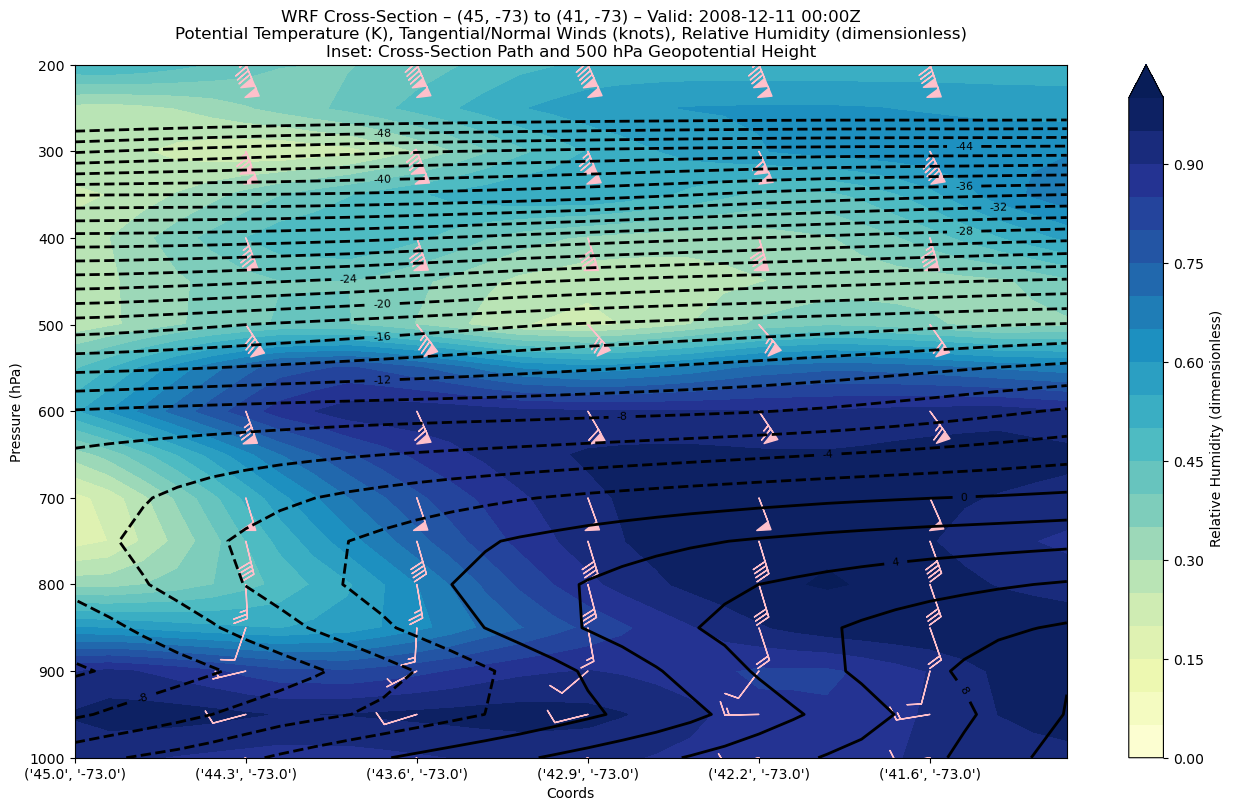

In [8]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot RH using contourf
rh_contour = ax.contourf(inds, Pc, RH,
                         levels=np.arange(0, 1.05, .05), cmap='YlGnBu', extend='max')
rh_colorbar = fig.colorbar(rh_contour)

# Plot potential temperature using contour, with some custom labeling
#theta_contour = ax.contour(inds, Pc, Thta.transpose(),
#                           levels=np.arange(250, 400, 10), colors='k', linewidths=2)
theta_contour = ax.contour(inds, Pc, T,
                           levels=np.arange(-50, 20, 2), colors='k', linewidths=2)
theta_contour.clabel(theta_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot winds using the axes interface directly, with some custom indexing to make the barbs
# less crowded
wind_slc_vert = list(range(0, 13, 2)) + list(range(13, 19))
wind_slc_horz = slice(5, 100, 5)
ax.barbs(inds[wind_slc_horz], Pc[wind_slc_vert],
         tan_wind[wind_slc_vert, wind_slc_horz],
         norm_wind[wind_slc_vert, wind_slc_horz], color='pink')

# Adjust the y-axis to be logarithmic if desired
## Omit if you wish to highlight the lower tropopsher
#ax.set_yscale('symlog')
ax.set_ylim(1000, 200)
ax.set_yticks(np.arange(1000, 150, -100))
ax.set_yticklabels(np.arange(1000, 150, -100))


# Define the CRS and inset axes
##data_crs = data['Geopotential_height'].metpy.cartopy_crs
##ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=data_crs)

# Plot geopotential height at 500 hPa using xarray's contour wrapper
##ax_inset.contour(data['x'], data['y'], data['Geopotential_height'].sel(isobaric=500.),
##                 levels=np.arange(5100, 6000, 60), cmap='inferno')

# Plot the path of the cross section
##endpoints = data_crs.transform_points(ccrs.Geodetic(),
 ##                                     *np.vstack([start, end]).transpose()[::-1])
##ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
##ax_inset.plot(cross['x'], cross['y'], c='k', zorder=2)

##Add geographic features
##ax_inset.coastlines()
##ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
##ax_inset.set_title('')
ax.set_title(f'WRF Cross-Section \u2013 {start} to {end} \u2013 '
             f'Valid: {cross["Time"].dt.strftime("%Y-%m-%d %H:%MZ").item()}\n'
             'Potential Temperature (K), Tangential/Normal Winds (knots), Relative Humidity '
             '(dimensionless)\nInset: Cross-Section Path and 500 hPa Geopotential Height')
ax.set_ylabel('Pressure (hPa)')
#ax.set_xlabel('Longitude (degrees east)')
ax.set_xlabel('Coords')
ax.set_xticks(range(0,30,5))
ax.set_xticklabels(xsec_coords[::5])
rh_colorbar.set_label('Relative Humidity (dimensionless)')
